# 酒馆和客人的故事

In [2]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

%matplotlib inline

In [3]:
data = {
    'tra': pd.read_csv('./data/air_visit_data.csv'),
    'as': pd.read_csv('./data/air_store_info.csv'),
    'hs': pd.read_csv('./data/hpg_store_info.csv'),
    'ar': pd.read_csv('./data/air_reserve.csv'),
    'hr': pd.read_csv('./data/hpg_reserve.csv'),
    'id': pd.read_csv('./data/store_id_relation.csv'),
    'tes': pd.read_csv('./data/sample_submission.csv'),
    'hol': pd.read_csv('./data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [72]:
# 初始处理:
#       1. 从tes数据id中提取air_store_id和visit_datetime
#       2. 在HPG预订信息中匹配air_store_id
#       2. 转换visit_datetime和reserve_datetime为时间格式
# 1.
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
# 2.
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
# 3.
for k in data:
    if 'visit_date' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_date'])
    if 'visit_datetime' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_datetime'].str.split().str[0])
        data[k].drop('visit_datetime', axis=1, inplace=True)
    if 'reserve_datetime' in data[k].columns:
        data[k]['reserve_date'] = pd.to_datetime(data[k]['reserve_datetime'].str.split().str[0])
        data[k].drop('reserve_datetime', axis=1, inplace=True)

In [73]:
# 辅助函数
def cat_cnt_plot(cnt, figsize=(14,4), style='seaborn-poster', xtick_rota=90):
    plt.style.use(style)
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.barplot(cnt.index, cnt, ax=ax)
    loc, labels = plt.xticks()
    _ = g.set_xticklabels(labels, rotation=xtick_rota)
    ax.set_ylabel('Count')
    return ax


In [5]:
data['tes'].head()

,id,visitors,visit_date,air_store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9


## 到店数据（训练数据）

In [5]:
data['tra'].dtypes

air_store_id    object
visit_date      object
visitors         int64
dtype: object

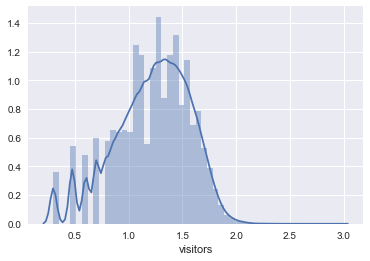

In [9]:
sns.distplot(np.log10(data['tra']['visitors']+1))

In [118]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [5]:
# 从训练数据中得到关于visitors的数据
visitors = data['tra'].groupby('visit_date')['visitors'].mean().to_frame(name='mean')
visitors.loc[:, 'all'] = data['tra'].groupby('visit_date')['visitors'].sum().to_frame(name='all')
visitors['month'] = visitors.index.month
visitors['dayofweek'] = visitors.index.dayofweek
# visitors['dayofweek'] = visitors['dayofweek'].map({0: 'Monday', 1: 'Tuesday',2: 'Wednesday', 3:'Thursday', 4: 'Friday', 5:'Saturday', 6: 'Sunday'})

In [123]:
visitors['store_num'] = data['tra'].groupby('visit_date')['air_store_id'].count()

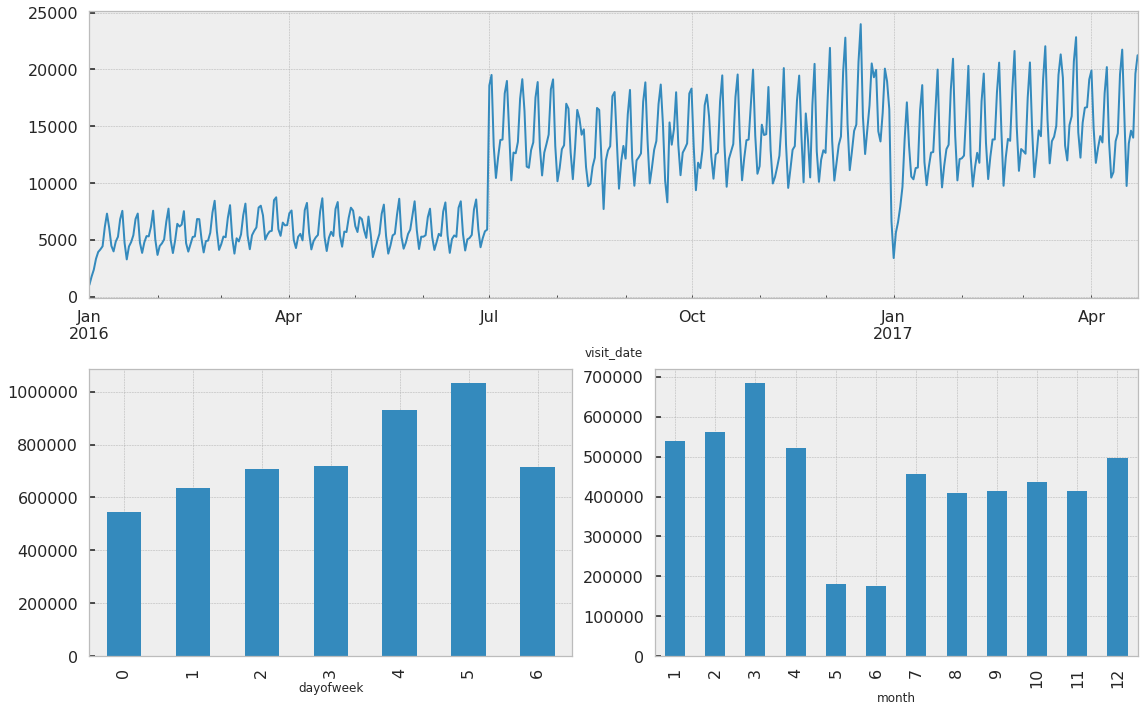

In [125]:
plt.style.use('bmh')
fig = plt.figure(figsize=(16, 10))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))

visitors['all'].plot(ax=ax0)
visitors.groupby('dayofweek')['all'].sum().plot.bar(ax=ax1)
visitors.groupby('month')['all'].sum().plot.bar(ax=ax2)

plt.tight_layout()

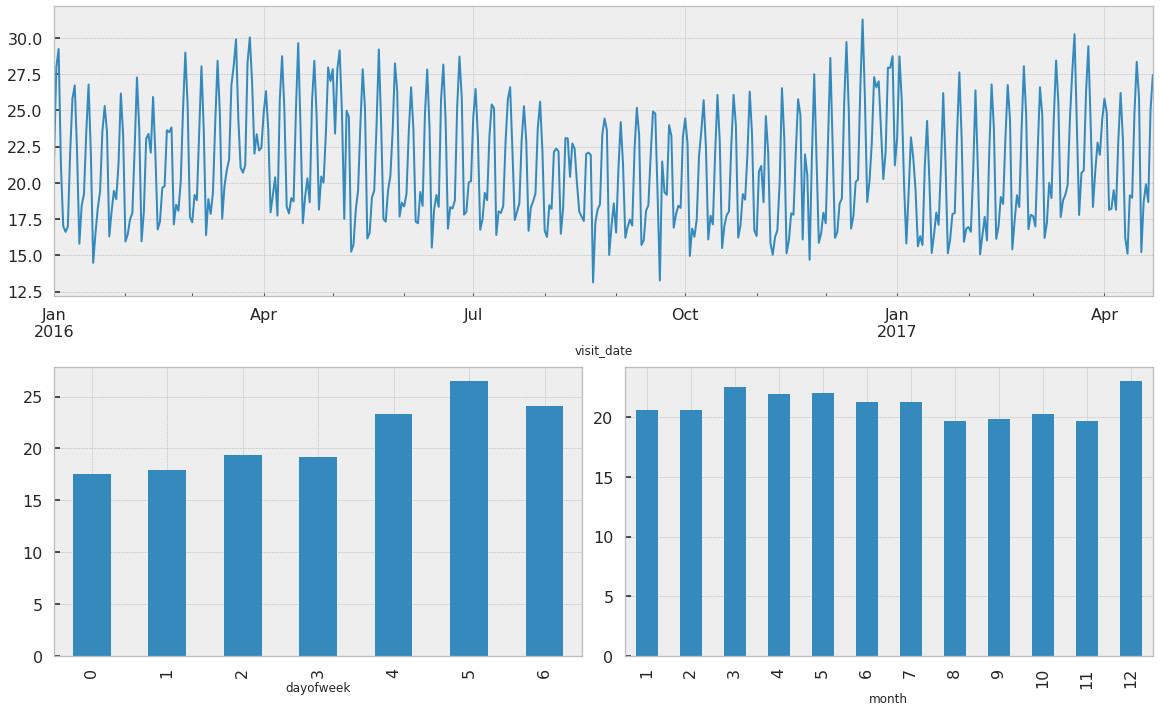

In [129]:
plt.style.use('bmh')
fig = plt.figure(figsize=(16, 10))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))

visitors['mean'].plot(ax=ax0)
visitors.groupby('dayofweek')['mean'].mean().plot.bar(ax=ax1)
visitors.groupby('month')['mean'].mean().plot.bar(ax=ax2)

plt.tight_layout()

In [7]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [74]:
# count / ratio
# data['tra'].groupby('air_store_id')['visitors'].sum()
def time_feats(df, dt_col='visit_date'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df.loc[:, 'year'] = df[dt_col].dt.year
    df.loc[:, 'dow'] = df[dt_col].dt.dayofweek
    df.loc[:, 'month'] = df[dt_col].dt.month
    df.loc[:, 'season'] = df[dt_col].dt.quarter
    df.loc[:, 'week'] = df[dt_col].dt.weekofyear
    df.loc[:, 'doy'] = df[dt_col].dt.dayofyear
    df.loc[:, 'date_int'] = df[dt_col].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

In [75]:
# 增加时间特征
time_feats(data['tra'])
time_feats(data['tes'])

# 匹配genre和area信息
data['tra'] = data['tra'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')
data['tes'] = data['tes'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')

In [7]:
data['tes'].tail()

,id,visitors,visit_date,air_store_id,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air_fff68b929994bfbd,2017,5,5,2,21,147,20170527,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air_fff68b929994bfbd,2017,6,5,2,21,148,20170528,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,2017,0,5,2,22,149,20170529,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,2017,1,5,2,22,150,20170530,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano
32018,air_fff68b929994bfbd_2017-05-31,0,2017-05-31,air_fff68b929994bfbd,2017,2,5,2,22,151,20170531,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano


### 1). 用餐人数
1. overall action count / ratio
2. monthly action count / ratio
3. penetration

In [8]:
data['tra'].head()

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,Dining bar,Tōkyō-to Minato-ku Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,Dining bar,Tōkyō-to Minato-ku Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,Dining bar,Tōkyō-to Minato-ku Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,2016,5,1,1,2,16,20160116,Dining bar,Tōkyō-to Minato-ku Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,2016,0,1,1,3,18,20160118,Dining bar,Tōkyō-to Minato-ku Shibakōen


In [54]:
# Store
# 1. overall
store_agg_all = data['tra'].groupby('air_store_id')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
store_cnt_monthly = data['tra'].groupby(['air_store_id', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
store_mean_std_monthly = store_cnt_monthly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_monthly = store_cnt_monthly.groupby(['air_store_id', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
store_agg_monthly.loc[:, 'ratio_m'] = store_agg_monthly['mean_m'] / store_mean_std_monthly['mean']

# 3. weekly data
store_cnt_weekly = data['tra'].groupby(['air_store_id', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
store_mean_std_weekly = store_cnt_weekly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_weekly = store_cnt_weekly.groupby(['air_store_id', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
store_agg_weekly.loc[:, 'ratio_w'] = store_agg_weekly['mean_w'] / store_mean_std_weekly['mean']

# 4. dow data
store_agg_dow = data['tra'].groupby(['air_store_id', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
store_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
store_agg_dow.loc[:, 'ratio_d'] = store_agg_dow['mean_d'] / store_agg_all['mean']

# 5. penetration
store_penetration = data['tra'].groupby('air_store_id')['visitors'].sum() / data['tra']['visitors'].sum()

In [55]:
# Genre
# 1. overall
genre_agg_all = data['tra'].groupby('air_genre_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_cnt_monthly = data['tra'].groupby(['air_genre_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_monthly = genre_cnt_monthly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_monthly = genre_cnt_monthly.groupby(['air_genre_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
genre_agg_monthly.loc[:, 'ratio_m'] = genre_agg_monthly['mean_m'] / genre_mean_std_monthly['mean']

# 3. weekly data
genre_cnt_weekly = data['tra'].groupby(['air_genre_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_weekly = genre_cnt_weekly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_weekly = genre_cnt_weekly.groupby(['air_genre_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
genre_agg_weekly.loc[:, 'ratio_w'] = genre_agg_weekly['mean_w'] / genre_mean_std_weekly['mean']

# 4. dow data
genre_agg_dow = data['tra'].groupby(['air_genre_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
genre_agg_dow.loc[:, 'ratio_d'] = genre_agg_dow['mean_d'] / genre_agg_all['mean']

# 5. penetration
genre_penetration = data['tra'].groupby('air_genre_name')['visitors'].sum() / data['tra']['visitors'].sum()

In [56]:
# Area
# 1. overall
area_agg_all = data['tra'].groupby('air_area_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
area_cnt_monthly = data['tra'].groupby(['air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
area_mean_std_monthly = area_cnt_monthly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_monthly = area_cnt_monthly.groupby(['air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
area_agg_monthly.loc[:, 'ratio_m'] = area_agg_monthly['mean_m'] / area_mean_std_monthly['mean']

# 3. weekly data
area_cnt_weekly = data['tra'].groupby(['air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
area_mean_std_weekly = area_cnt_weekly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_weekly = area_cnt_weekly.groupby(['air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
area_agg_weekly.loc[:, 'ratio_w'] = area_agg_weekly['mean_w'] / area_mean_std_weekly['mean']

# 4. dow data
area_agg_dow = data['tra'].groupby(['air_area_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
area_agg_dow.loc[:, 'ratio_d'] = area_agg_dow['mean_d'] / area_agg_all['mean']

# 5. penetration
area_penetration = data['tra'].groupby('air_area_name')['visitors'].sum() / data['tra']['visitors'].sum()

In [57]:
# genre X area
data['tra']['air_area_name1'] = data['tra']['air_area_name'].apply(lambda x: x.split()[0].split('-')[0])
data['tra']['air_area_name2'] = data['tra']['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

# 1. overall count
genre_area_cnt_all = data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_area_cnt_monthly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']

# genre_area_agg_monthly.loc['ratio_m'] = genre_area_agg_monthly['mean_m'] / genre_area_mean_std_monthly['mean'] # 比率属性: 报错了

# 3. weekly data
genre_area_cnt_weekly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']

# 4. dow data
genre_area_agg_dow = data['tra'].groupby(['air_genre_name', 'air_area_name', 'dow'])['visitors'].agg(
                                      [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
# genre_area_agg_dow.loc[:, 'ratio_d'] = genre_area_agg_dow['mean_d'] / genre_area_cnt_all['mean']
# NotImplementedError: merging with more than one level overlap on a multi-index is not implemented

# 5. penetration
genre_area_penetration = data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].sum() / data['tra']['visitors'].sum()

# WARNING: 多样性信息可以加上HPG系统的store信息，可以两边都用
# 6. diversity
genre_area_num = data['tra'][['air_store_id', 'air_genre_name', 'air_area_name']].groupby([
    'air_genre_name', 'air_area_name'])['air_store_id'].nunique().to_frame().reset_index()
genre_num = data['tra'].groupby('air_genre_name')['air_store_id'].nunique()
area_num = data['tra'].groupby('air_area_name')['air_store_id'].nunique()

genre_area_num = genre_area_num.merge(area_num.to_frame(name='area_store_num'), how='left', left_on='air_area_name', right_index=True)
genre_area_num = genre_area_num.merge(genre_num.to_frame(name='genre_store_num'), how='left', left_on='air_genre_name', right_index=True)
genre_area_num.loc[:, 'area_store_ratio'] = genre_area_num['air_store_id'] / genre_area_num['area_store_num']
genre_area_num.loc[:, 'genre_store_ratio'] = genre_area_num['air_store_id'] / genre_area_num['genre_store_num']

### +hpg 区域和类型

In [84]:
genre_hpg2air = {'Japanese style':   'Japanese food',
'Italian':  'Italian/French',
'International cuisine':    'International cuisine',
'Grilled meat':     'Yakiniku/Korean food',
'Creation':     'Creative cuisine',
'Shabu-shabu/Sukiyaki':     'Other',
'Korean cuisine':   'Asian',
'Creative Japanese food':   'Creative cuisine',
'Japanese cuisine/Kaiseki':     'Japanese food',
'Seafood':  'Other',
'Japanese food in general':     'Japanese food',
'Party':    'Karaoke/Party',
'Okonomiyaki/Monja/Teppanyaki':     'Okonomiyaki/Monja/Teppanyaki',
'Sushi':    'Japanese food',
'Spain Bar/Italian Bar':    'Italian/French',
'Chinese general':  'Asian',
'Bistro':   'Other',
'French':   'Western food',
'Karaoke':  'Karaoke/Party',
'Pasta/Pizza':  'Western food',
'Cafe':     'Cafe/Sweets',
'Sweets':   'Cafe/Sweets',
'Steak/Hamburger/Curry':    'Other',
'Thai/Vietnamese food':     'Asian',
'Western food':     'Western food',
'Taiwanese/Hong Kong cuisine':  'Asian',
'Cantonese food':   'Asian',
'Bar/Cocktail':     'Bar/Cocktail',
'Dim Sum/Dumplings':    'Asian',
'Amusement bar':    'Dining bar',
'Sichuan food':     'Asian',
'Shanghai food':    'Asian',
'Spain/Mediterranean cuisine':  'Western food',
'Udon/Soba':    'Japanese food'}


In [88]:
# 转换HPG类型 --> AIR类型，添加area2字段
data['hs']['air_genre_name'] = data['hs']['hpg_genre_name'].map(genre_hpg2air)
data['as']['area2'] = data['as']['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))
data['hs']['area2'] = data['hs']['hpg_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

In [126]:
# 类型 X 区域商家汇总
genre_area_num_all = data['as'].groupby(['air_genre_name', 'area2'])['air_store_id'].count().to_frame('#air_store').merge(
    data['hs'].groupby(['air_genre_name', 'area2'])['hpg_store_id'].count().to_frame('#hpg_store'),
    how='left',
    left_index=True, right_index=True).fillna(0)
genre_area_num_all['#store_all'] = genre_area_num_all['#air_store'] + genre_area_num_all['#hpg_store']
genre_area_num_all.drop(['#air_store', '#hpg_store'], axis=1, inplace=True)

# 区域商家总计
area_num_all = data['as'].groupby('area2')['air_store_id'].count().to_frame('#air_store').merge(
    data['hs'].groupby('area2')['hpg_store_id'].count().to_frame('#hpg_store'),
    how='left',
    left_index=True, right_index=True).fillna(0)
area_num_all['#store_area'] = area_num_all['#air_store'] + area_num_all['#hpg_store']
area_num_all.drop(['#air_store', '#hpg_store'], axis=1, inplace=True)

# 类型商家总计
# genre_num_all
genre_num_all = data['as'].groupby('air_genre_name')['air_store_id'].count().to_frame('#air_store').merge(
    data['hs'].groupby('air_genre_name')['hpg_store_id'].count().to_frame('#hpg_store'),
    how='left',
    left_index=True, right_index=True).fillna(0)
genre_num_all['#store_genre'] = genre_num_all['#air_store'] + genre_num_all['#hpg_store']
genre_num_all.drop(['#air_store', '#hpg_store'], axis=1, inplace=True)

# 计算地区和类型penetration
genre_area_num_all = genre_area_num_all.merge(area_num_all, how='left', left_index=True, right_index=True).merge(genre_num_all, how='left', left_index=True, right_index=True)
genre_area_num_all['area_store_ratio'] = genre_area_num_all['#store_all'] / genre_area_num_all['#store_area']
genre_area_num_all['genre_store_ratio'] = genre_area_num_all['#store_all'] / genre_area_num_all['#store_genre']

### 2). 预订人数
1. overall action count / ratio
2. monthly action count / ratio
3. penetration


In [7]:
data['ar'].head()

,air_store_id,reserve_visitors,visit_date,reserve_date
0,air_877f79706adbfb06,1,2016-01-01,2016-01-01
1,air_db4b38ebe7a7ceff,3,2016-01-01,2016-01-01
2,air_db4b38ebe7a7ceff,6,2016-01-01,2016-01-01
3,air_877f79706adbfb06,2,2016-01-01,2016-01-01
4,air_db80363d35f10926,5,2016-01-01,2016-01-01


In [8]:
data['tra'].head()

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,Dining bar,Tōkyō-to Minato-ku Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,Dining bar,Tōkyō-to Minato-ku Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,Dining bar,Tōkyō-to Minato-ku Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,2016,5,1,1,2,16,20160116,Dining bar,Tōkyō-to Minato-ku Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,2016,0,1,1,3,18,20160118,Dining bar,Tōkyō-to Minato-ku Shibakōen


In [ ]:
data['ar']['air_store_id'].unique()

In [21]:
# 全部预定数据
rv =data['ar'].merge(data['hr'], how='left', on=['air_store_id', 'reserve_date'], suffixes=('_air', '_hpg'))
rv.drop('hpg_store_id', axis=1, inplace=True)
rv['reserve_visitors_hpg'] = rv['reserve_visitors_hpg'].fillna(0)
rv.loc[rv['visit_date_hpg'].isnull(), 'visit_date_hpg'] = rv.loc[rv['visit_date_hpg'].isnull(), 'visit_date_air']
rv.loc[:, 'reserve_visitors'] = rv['reserve_visitors_air'] + rv['reserve_visitors_hpg']
rv.head()

,air_store_id,reserve_visitors_air,visit_date_air,reserve_date,reserve_visitors_hpg,visit_date_hpg,reserve_visitors
0,air_877f79706adbfb06,1,2016-01-01,2016-01-01,0.0,2016-01-01,1.0
1,air_db4b38ebe7a7ceff,3,2016-01-01,2016-01-01,0.0,2016-01-01,3.0
2,air_db4b38ebe7a7ceff,6,2016-01-01,2016-01-01,0.0,2016-01-01,6.0
3,air_877f79706adbfb06,2,2016-01-01,2016-01-01,0.0,2016-01-01,2.0
4,air_db80363d35f10926,5,2016-01-01,2016-01-01,4.0,2016-01-01,9.0


/home/shenc/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


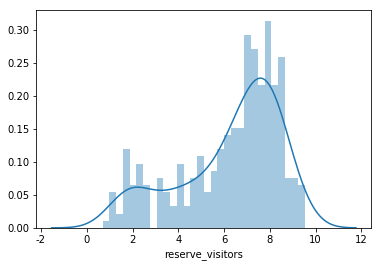

In [26]:
sns.distplot(np.log1p(rv.groupby('air_store_id')['reserve_visitors'].sum()), bins=30)

### 假期数据

**TO DO**
1. 黄金周的影响

In [27]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
# data['hol'].set_index('visit_date', inplace=True)
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [6]:
annos = data['hol'].groupby('holiday_flg')['holiday_flg'].count()
annos[0]

482

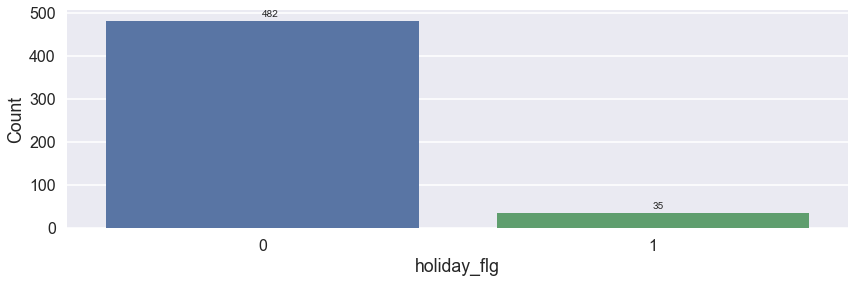

In [89]:
annos = data['hol'].groupby('holiday_flg')['holiday_flg'].count()
ax = cat_cnt_plot(annos, xtick_rota=0)
for i in annos.index:
    ax.annotate(annos[i], xy=(i, annos[i]), xytext=(i, annos[i]+10))

In [152]:
holiday = data['tra'].merge(data['hol'][['visit_date', 'holiday_flg']], on='visit_date', how='left')
holiday.loc[:, 'dow'] = holiday['visit_date'].dt.dayofweek
holiday.loc[:, 'month'] = holiday['visit_date'].dt.month

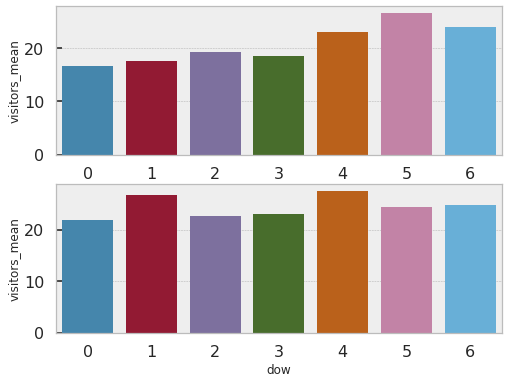

In [164]:
# 假期和非假期的一周每天平均客人数量
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 6))
tmp = holiday.groupby(['holiday_flg', 'dow'])['visitors'].mean().to_frame('visitors_mean').reset_index()
sns.barplot(tmp[tmp['holiday_flg']==0]['dow'], tmp[tmp['holiday_flg']==0]['visitors_mean'], ax=ax0)
sns.barplot(tmp[tmp['holiday_flg']==1]['dow'], tmp[tmp['holiday_flg']==1]['visitors_mean'], ax=ax1)

In [176]:
# tmp = 
pd.pivot_table(data=data['hol'], index='holiday_flg', columns='day_of_week', aggfunc=np.count_nonzero).values

array([[69, 65, 69, 70, 66, 72, 71],
       [ 5,  9,  5,  4,  7,  2,  3]])

In [31]:
data['hol'].tail()

,visit_date,day_of_week,holiday_flg
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


In [32]:
data['tra'] = data['tra'].merge(data['hol'][['visit_date', 'holiday_flg']], how='left', on='visit_date')

In [33]:
data['tra'].head(3)

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,Dining bar,Tōkyō-to Minato-ku Shibakōen,0
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,Dining bar,Tōkyō-to Minato-ku Shibakōen,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,Dining bar,Tōkyō-to Minato-ku Shibakōen,0


In [68]:
hol = data['tra'].groupby(['air_store_id', 'holiday_flg'])['visitors'].mean().unstack().fillna(0)
hol.columns = ['not_hol', 'is_hol']
hol['ratio'] = hol['is_hol'] / hol['not_hol']

In [69]:
hol.sort_values(by='ratio', ascending=False).tail(15)

,not_hol,is_hol,ratio
air_store_id,,,
air_2aab19554f91ff82,35.029178,6.615385,0.188854
air_9cf2f1ba86229773,31.290323,4.000000,0.127835
air_cc35590cd1da8554,19.956522,2.000000,0.100218
air_54ed43163b7596c4,16.441270,0.000000,0.000000
air_cd4b301d5d3918d8,6.127660,0.000000,0.000000
air_d63cfa6d6ab78446,18.432990,0.000000,0.000000
air_c66dbd2c37832d00,16.237374,0.000000,0.000000
air_900d755ebd2f7bbd,82.200000,0.000000,0.000000
air_105a7954e32dba9b,47.260417,0.000000,0.000000


In [180]:
# 构建原始的store_agg_dow
unique_stores = data['tra']['air_store_id'].unique()
store_agg_dow = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i] * len(unique_stores), 'holiday_flg': [j] * len(unique_stores)})
                           for i in range(7) for j in range(2)],
                           axis=0, ignore_index=True).reset_index(drop=True)

In [191]:
store_agg_all = data['tra'].groupby('air_store_id')['visitors'].agg([
    np.min, np.mean, np.median, np.max, np.std, np.sum])

store_agg_dow_all = data['tra'].groupby(['air_store_id', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
store_agg_dow_all.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
store_agg_dow_all.loc[:, 'ratio_d'] = store_agg_dow_all['mean_d'] / store_agg_all['mean']

store_agg_dow_hol = data['tra'].groupby(['air_store_id', 'dow', 'holiday_flg'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size]).fillna(0)
store_agg_dow_hol.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
# store_agg_dow_hol.loc[:, 'ratio_d'] = store_agg_dow_hol['mean_d'] / store_agg_all['mean']
store_agg_dow_hol.loc[:, 'ratio_d'] = store_agg_dow_hol['mean_d'] / store_agg_all['mean']

In [192]:
# 匹配 air_store_id, dow, holiday_flg 聚合数据
store_agg_tmp = store_agg_dow.merge(store_agg_dow_hol, how='left', left_on=['air_store_id', 'dow', 'holiday_flg'], right_index=True)

# 匹配air_store_id, dow, holiday_flg留下的空值，用air_store_id, dow匹配
store_agg_tmp1 = store_agg_tmp.loc[store_agg_tmp.drop(['air_store_id', 'dow', 'holiday_flg'], axis=1).isnull().all(axis=1)][['air_store_id', 'dow', 'holiday_flg']]
# store_agg_tmp1 = store_agg_tmp1.merge(store_agg_dow_all, how='left', left_on=['air_store_id', 'dow'], right_index=True)
store_agg_tmp1 = store_agg_tmp1.merge(store_agg_dow_all, how='left', left_on=['air_store_id', 'dow'], right_index=True)

# 匹配air_store_id, dow留下的空值，用air_store_id匹配
store_agg_tmp2 = store_agg_tmp1.loc[store_agg_tmp1.drop(['air_store_id', 'dow', 'holiday_flg'], axis=1).isnull().all(axis=1)][['air_store_id', 'dow', 'holiday_flg']]
store_agg_tmp2 = store_agg_tmp2.merge(store_agg_all.drop('sum', axis=1), how='left', left_on='air_store_id', right_index=True)
store_agg_tmp2 = store_agg_tmp2.merge(store_agg_dow_all.groupby('air_store_id')['len_d'].mean().to_frame(), how='left', left_on='air_store_id', right_index=True)
store_agg_tmp2['ratio_d'] = 1
store_agg_tmp2.columns = ['air_store_id', 'dow', 'holiday_flg', 'min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d', 'ratio_d']
# 从store_agg_tmp中剔除store_agg_tmp1, 从store_agg_tmp1中剔除store_agg_tmp2
store_agg_tmp.drop(store_agg_tmp1.index, inplace=True)
store_agg_tmp1.drop(store_agg_tmp2.index, inplace=True)

store_agg_dow = pd.concat([store_agg_tmp, store_agg_tmp1, store_agg_tmp2])


In [194]:
tmp.head()

,air_store_id,dow,holiday_flg,min_d,mean_d,median_d,max_d,std_d,len_d,ratio_d
0,air_ba937bf13d40fb24,0,0,2.0,13.754386,12.0,34.0,7.349151,57.0,0.603723
1,air_25e9888d30b386df,0,0,1.0,1.500000,1.5,2.0,0.707107,2.0,0.222428
2,air_8e4360a64dbd4c50,0,0,2.0,22.457143,21.0,43.0,8.451741,35.0,0.824761
3,air_35512c42db0868da,0,0,2.0,7.620000,8.0,16.0,3.238102,50.0,0.777058
4,air_a271c9ba19e81d17,0,0,8.0,20.142857,20.0,35.0,7.373015,35.0,0.776440


### 预定信息

In [199]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [200]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [214]:
data['hr'].shape

(28183, 6)

### hpg和air的预定信息中的商家不一样！
所以下面的方法可能有问题...

In [8]:
# 增加source，表示预定信息来源
data['hr'] = data['hr'].merge(data['id'], on='hpg_store_id')
data['hr'].loc[:, 'src'] = 'h'
data['ar'].loc[:, 'src'] = 'a'

In [9]:
# 把hpg和air的预定信息合并为reserve，方便处理
cols = ['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors', 'src']
reserve = pd.concat([data['ar'], data['hr'][cols]])

for col in ['visit_datetime', 'reserve_datetime']:
    reserve[col] = pd.to_datetime(reserve[col])

In [13]:
reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,src
28178,air_84f6876ff7e83ae7,2017-04-01 21:00:00,2017-03-10 20:00:00,2,h
28179,air_84f6876ff7e83ae7,2017-04-02 17:00:00,2017-04-02 14:00:00,2,h
28180,air_84f6876ff7e83ae7,2017-04-08 19:00:00,2017-04-03 12:00:00,3,h
28181,air_84f6876ff7e83ae7,2017-04-08 20:00:00,2017-03-09 07:00:00,4,h
28182,air_84f6876ff7e83ae7,2017-04-28 18:00:00,2017-04-10 22:00:00,5,h


In [20]:
print('Total reserves: {}'.format(data['hr'].shape[0] + data['ar'].shape[0]))
print('Air ratio: {:5.3f}'.format( data['ar'].shape[0] / (data['hr'].shape[0] + data['ar'].shape[0])))
print('Hpg ratio: {:5.3f}'.format( data['hr'].shape[0] / (data['hr'].shape[0] + data['ar'].shape[0])))

Total reserves: 120561
Air ratio: 0.766
Hpg ratio: 0.234


In [10]:
# rv: 预定量    rv_visit: 当天预约会到店的人数
rv = reserve.groupby(reserve['reserve_datetime'].dt.date)['reserve_visitors'].sum()
rv.index = pd.to_datetime(rv.index)

rv_visit = reserve.groupby(reserve['visit_datetime'].dt.date)['reserve_visitors'].sum()
rv_visit.index = pd.to_datetime(rv_visit.index)

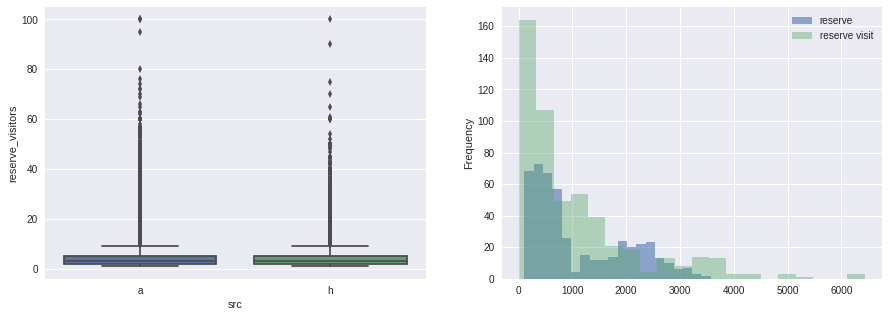

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))

# 不同来源的预定量
sns.boxplot(x='src', y='reserve_visitors', data=reserve, ax=ax0)

# 当天的预定量 vs 预约到店人数
rv.plot.hist(alpha=0.6, ax=ax1, bins=20)
rv_visit.plot.hist(alpha=0.4, ax=ax1, bins=20)
ax1.legend(['reserve', 'reserve visit'])

---
**实际到店人数 vs 预定人数**

---

In [12]:
rv_and_visit = pd.DataFrame({'visitors': visitors['count'], 'rv': rv, 'rv_visit': rv_visit})

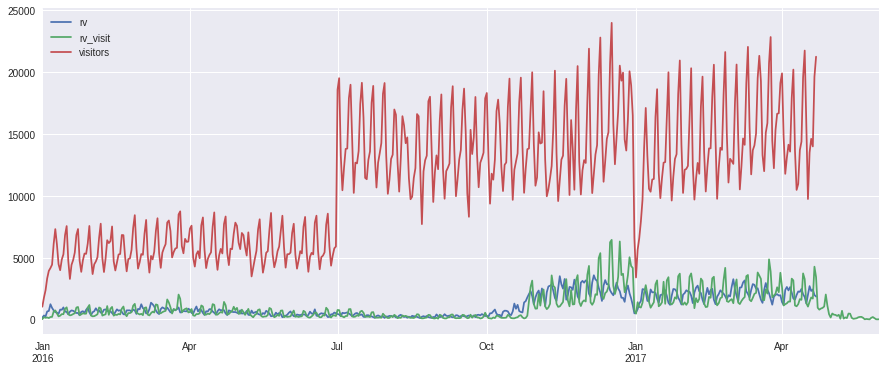

In [13]:
rv_and_visit.plot(figsize=(15, 6))

## 商家信息
---
**FINDINGS**
1. 训练集中的商家都是air系统中的商家，且两边商家数一致
2. 所欲HPG系统的商家信息不参与训练，可以用来提取商家类型、区域商家数量（密度）、类型多样性之类的特征

In [6]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [7]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [14]:
data['as'].groupby(['air_area_name', 'latitude', 'longitude'])['air_store_id'].count().to_frame().reset_index().to_csv('air_area.csv')

In [84]:
capital = {'Fukuoka-ken': 'Fukuoka-shi',
'Fukuoka-ken': 'Itoshima-shi',
'Hiroshima-ken': 'Hiroshima-shi',
'Hyōgo-ken': 'Kōbe-shi',
'Miyagi-ken': 'Sendai-shi',
'Niigata-ken': 'Niigata-shi',
'Ōsaka-fu': 'Ōsaka-shi',
'Shizuoka-ken': 'Shizuoka-shi',
'Tōkyō-to': 0,
'Hokkaidō': 'Sapporo-shi'}

### 和中心区的距离

In [85]:
air_area = data['as'].copy()

In [86]:
air_area['area1'] = air_area['air_area_name'].str.split().str[0]
air_area['area2'] = air_area['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

In [87]:
capital_coor = air_area.loc[air_area['air_area_name'].str.split().str[1].isin(capital.values())].groupby('area1')[['latitude', 'longitude']].mean()
capital_coor.columns = ['latitude_cap', 'longitude_cap']
tokyo_coor = air_area.loc[air_area['air_area_name'].str.startswith('Tōkyō')].groupby('area1')[['latitude', 'longitude']].mean()
tokyo_coor.columns = ['latitude_cap', 'longitude_cap']
capital_coor = pd.concat([capital_coor, tokyo_coor])
air_area = air_area.merge(capital_coor, how='left', left_on='area1', right_index=True)

air_area['dist2cap'] = np.sqrt(np.abs(
    np.power( air_area['latitude'] - air_area['latitude_cap'] , 2) -
    np.power( air_area['longitude'] - air_area['longitude_cap'], 2)
    ))
air_area['dist2tokyo'] = np.sqrt(np.abs(
    np.power( air_area['latitude'] - capital_coor.loc['Tōkyō-to', 'latitude_cap'] , 2) -
    np.power( air_area['longitude'] - capital_coor.loc['Tōkyō-to', 'longitude_cap'], 2)
    ))
capital_coor

,latitude_cap,longitude_cap
area1,,
Fukuoka-ken,33.557320,130.195555
Hiroshima-ken,34.386462,132.455664
Hokkaidō,43.059303,141.345547
Hyōgo-ken,34.700598,135.213229
Miyagi-ken,38.269076,140.870403
Niigata-ken,37.903724,139.017011
Shizuoka-ken,34.975140,138.383243
Ōsaka-fu,34.689319,135.504201
Tōkyō-to,35.675963,139.712946


In [88]:
air_area.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,area1,area2,latitude_cap,longitude_cap,dist2cap,dist2tokyo
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,34.700598,135.213229,0.014369,4.407270
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,34.700598,135.213229,0.014369,4.407270
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,34.700598,135.213229,0.014369,4.407270
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,34.700598,135.213229,0.014369,4.407270
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku,35.675963,139.712946,0.034261,0.034261


In [52]:
air_area.loc[air_area['dist2cap'] > 1, 'dist2cap'] = 1

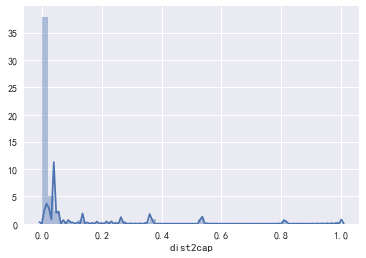

In [53]:
sns.distplot(air_area['dist2cap'])

In [89]:
# 在训练数据上加上和中心区的举例
air_area_dist = data['tra'].groupby('air_store_id')['visitors'].mean().to_frame().merge(air_area[['air_store_id', 'dist2cap', 'dist2tokyo']],
                                                                        how='left', left_index=True, right_on='air_store_id')

In [90]:
air_area_dist.head()

,visitors,air_store_id,dist2cap,dist2tokyo
87,26.081897,air_00a91d42b08b08d9,0.036427,0.036427
10,9.248322,air_0164b9927d20bcc3,0.034261,0.034261
554,9.896465,air_0241aa3964b7f861,0.056150,0.056150
198,7.939655,air_0328696196e46f18,0.020680,4.069768
374,14.828685,air_034a3d5b40d5b1b1,0.031829,4.125065


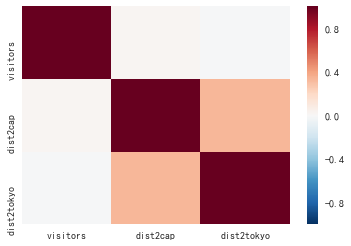

In [96]:
sns.heatmap(air_area_dist.drop('air_store_id', axis=1).corr())

## 餐厅类型

In [11]:
for i in data['as']['air_genre_name'].unique():
    print(i)

Italian/French
Dining bar
Yakiniku/Korean food
Cafe/Sweets
Izakaya
Okonomiyaki/Monja/Teppanyaki
Bar/Cocktail
Japanese food
Creative cuisine
Other
Western food
International cuisine
Asian
Karaoke/Party


In [24]:
# 对处理genre_name的探索
sim_genre = lambda x: re.sub('( food in general| food)', '', x)
sim_genre('Seafood')

'Seafood'

In [10]:
for i in data['hs']['hpg_genre_name'].unique():
    print(i)

Japanese style
Italian
International cuisine
Grilled meat
Creation
Shabu-shabu/Sukiyaki
Korean cuisine
Creative Japanese food
Japanese cuisine/Kaiseki
Seafood
Japanese food in general
Party
Okonomiyaki/Monja/Teppanyaki
Sushi
Spain Bar/Italian Bar
Chinese general
Bistro
French
Karaoke
Pasta/Pizza
Cafe
Sweets
Steak/Hamburger/Curry
Thai/Vietnamese food
Western food
Taiwanese/Hong Kong cuisine
Cantonese food
Bar/Cocktail
Dim Sum/Dumplings
Amusement bar
Sichuan food
Shanghai food
Spain/Mediterranean cuisine
Udon/Soba


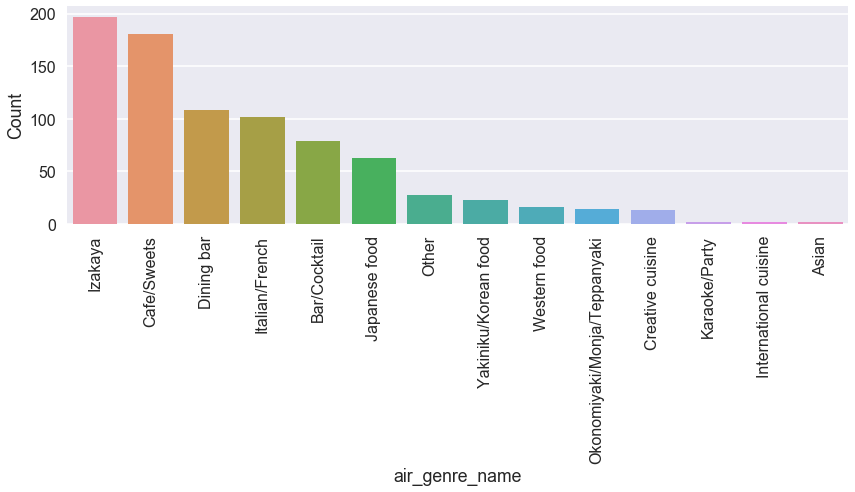

In [72]:
as_genre_cnt = data['as'].groupby('air_genre_name')['air_store_id'].count().sort_values(ascending=False)
cat_cnt_plot(as_genre_cnt)

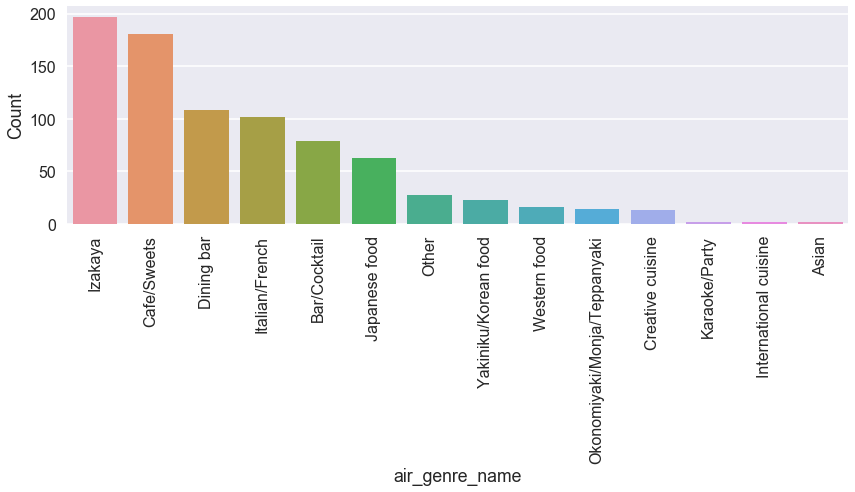

In [73]:
# air餐厅品类分布
as_genre_cnt = data['as'].groupby('air_genre_name')['air_store_id'].count().sort_values(ascending=False)
cat_cnt_plot(as_genre_cnt)

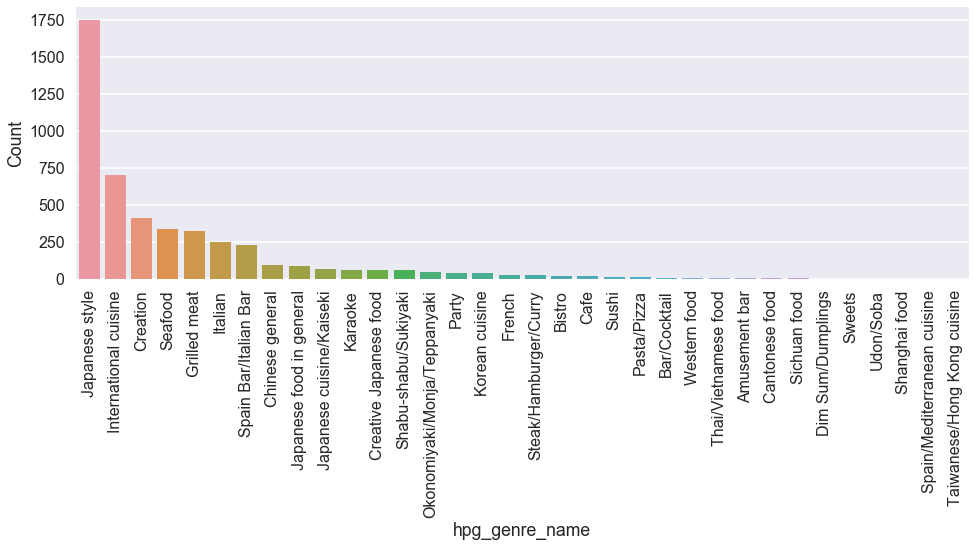

In [75]:
# hpg餐厅品类分布
hs_genre_cnt = data['hs'].groupby('hpg_genre_name')['hpg_store_id'].count().sort_values(ascending=False)
cat_cnt_plot(hs_genre_cnt, figsize=(16, 5))

## 餐厅类型 X 客人数

**当前特征：**
1. 类型名称编码
2. ...

**待定：**
1. 类型 x visitors
2. 类型 x 日期 x visitors: 类型在时间上的变化
3. 类型 x 区域: 区域-类型密度等信息
4. 类型 x 区域 x visitors

In [14]:
visitors_x_as = data['tra'].merge(data['as'], how='left', on='air_store_id')

In [19]:
visitors_x_as.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [29]:
visitors_x_as.groupby('air_genre_name')['air_store_id'].nunique()

air_genre_name
Asian                             2
Bar/Cocktail                     79
Cafe/Sweets                     181
Creative cuisine                 13
Dining bar                      108
International cuisine             2
Italian/French                  102
Izakaya                         197
Japanese food                    63
Karaoke/Party                     2
Okonomiyaki/Monja/Teppanyaki     14
Other                            27
Western food                     16
Yakiniku/Korean food             23
Name: air_store_id, dtype: int64

### 商家类型 x visitors

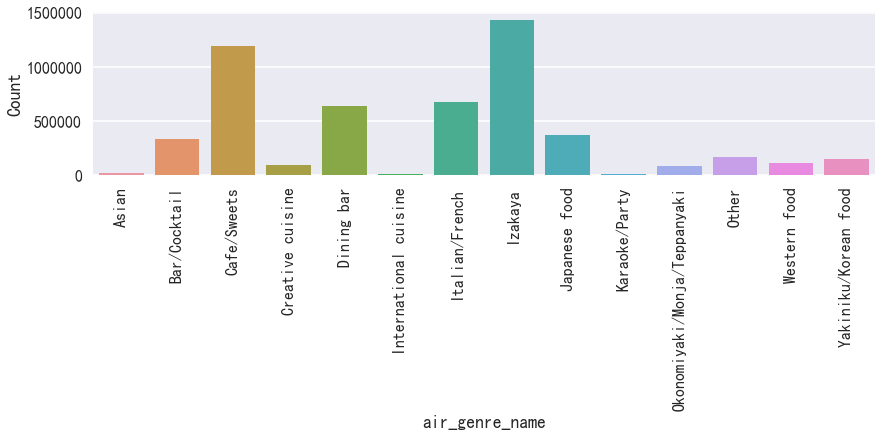

In [30]:
# 类型每日总量
#     : 总量可能和对应类型的商家数量有关

cat_cnt_plot(visitors_x_as.groupby('air_genre_name')['visitors'].sum(), figsize=(14,3))

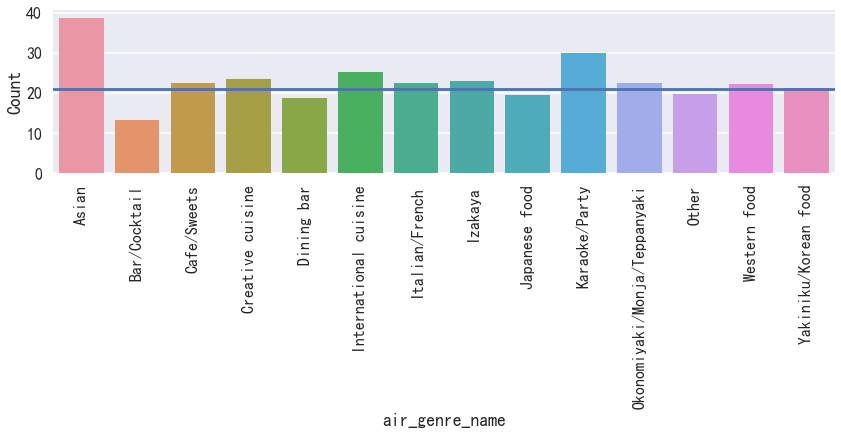

In [45]:
# 每天各类商家的平均客户量

ax = cat_cnt_plot(visitors_x_as.groupby('air_genre_name')['visitors'].mean(), figsize=(14,3))
ax.axhline(visitors_x_as.visitors.mean())

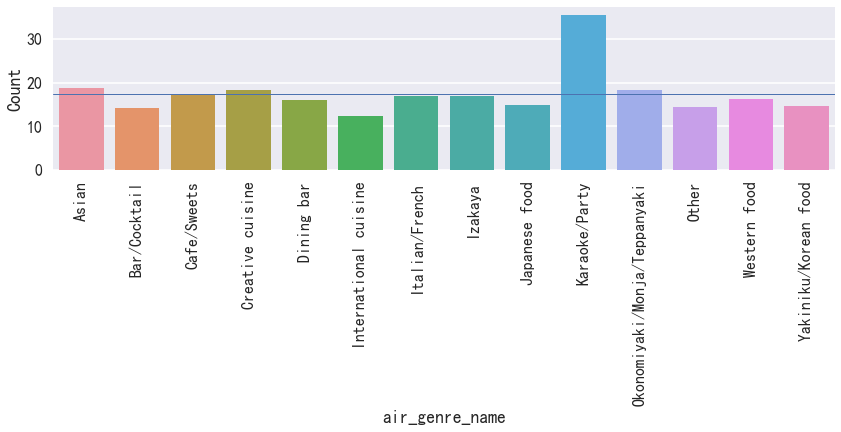

In [49]:
# 各类型商家在整个时间区间上的平均客人量

ax = cat_cnt_plot(visitors_x_as.groupby('air_genre_name')['visitors'].std(), figsize=(14,3))
ax.axhline(visitors_x_as.groupby('air_genre_name')['visitors'].std().mean(), linewidth=1)

### 商家类型 x visitors - 结论
1. 各商家在整个时间区间上的客人总量有明显区别，居酒屋和咖啡店最多，这和店铺数量分布是一致的
2. 日均和总平均客户量最多的三个（asian, inter, karaoke）都只有2家店
3. 除了Karaoke的日均客户量方差较大外，其他都差不多，有可能是因为极值(也有可能是outlier)的关系，因为visitors最大的前2家店都是karaoke

---
### 类型 x 时间 x visitors

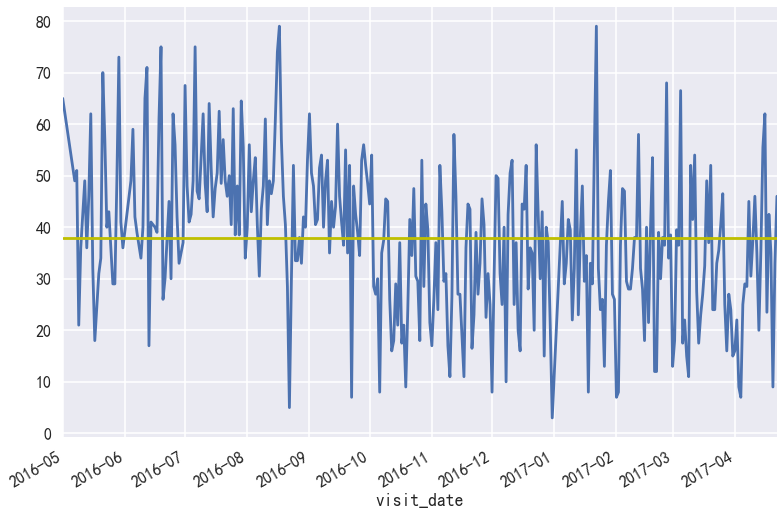

In [70]:
tmp_sum = visitors_x_as.groupby(['air_genre_name', 'visit_date'])['visitors'].sum()
tmp_mean = visitors_x_as.groupby(['air_genre_name', 'visit_date'])['visitors'].mean()

_ = tmp_mean.loc['Asian'].plot()
_.axhline(tmp_mean.loc['Asian'].mean(), color='y')

### Market Share

In [6]:
visitors = data['tra'].merge(data['as'], how='left', on='air_store_id')

In [10]:
visitors.groupby('air_genre_name')['visitors'].sum().to_frame()

,visitors
air_genre_name,
Asian,20730
Bar/Cocktail,334515
Cafe/Sweets,1192802
Creative cuisine,91285
Dining bar,640195
International cuisine,9378
Italian/French,677737
Izakaya,1432337
Japanese food,367352


### 类型市场占有率

In [16]:
genre_sum = visitors.groupby(['air_store_id', 'air_genre_name'])['visitors'].sum().to_frame()
genre_share = visitors.groupby(['air_store_id', 'air_genre_name'])['visitors'].sum().to_frame() /\
                      visitors.groupby('air_genre_name')['visitors'].sum().to_frame()

In [28]:
np.corrcoef(np.log1p(genre_sum['visitors']), np.log1p(genre_share['visitors']))

array([[1.        , 0.20710831],
       [0.20710831, 1.        ]])

### 区域市场占有率

In [29]:
visitors.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [46]:
# 按照详细地区汇总
area_sum = visitors.groupby(['air_store_id', 'air_area_name'])['visitors'].sum().to_frame()
area_share = visitors.groupby(['air_store_id', 'air_area_name'])['visitors'].sum().to_frame() /\
                      visitors.groupby('air_area_name')['visitors'].sum().to_frame()

In [36]:
np.corrcoef(np.log1p(area_sum['visitors']), np.log1p(area_share['visitors']))

array([[1.        , 0.30127571],
       [0.30127571, 1.        ]])

In [37]:
visitors['area1'] = visitors['air_area_name'].str.split().str[0]
visitors['area2'] = visitors['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

In [40]:
# 按照一级地区汇总
area1_sum = visitors.groupby(['air_store_id', 'area1'])['visitors'].sum().to_frame()
area1_share = visitors.groupby(['air_store_id', 'area1'])['visitors'].sum().to_frame() /\
                      visitors.groupby('area1')['visitors'].sum().to_frame()

In [41]:
np.corrcoef(area1_sum['visitors'], area1_share['visitors'])

array([[1.        , 0.40337492],
       [0.40337492, 1.        ]])

In [42]:
# 按照二级地区汇总
area2_sum = visitors.groupby(['air_store_id', 'area2'])['visitors'].sum().to_frame()
area2_share = visitors.groupby(['air_store_id', 'area2'])['visitors'].sum().to_frame() /\
                      visitors.groupby('area2')['visitors'].sum().to_frame()

In [43]:
np.corrcoef(area2_sum['visitors'], area2_share['visitors'])

array([[1.        , 0.29912695],
       [0.29912695, 1.        ]])

## 餐厅区域

In [57]:
print("Air系统中共有{}个区域。".format(len(data['as']['air_area_name'].unique())))
print("Hpg系统中共有{}个区域。".format(len(data['hs']['hpg_area_name'].unique())))

Air系统中共有103个区域。
Hpg系统中共有119个区域。


In [60]:
from random import shuffle

as_stores_area_name = data['as']['air_area_name'].unique()
hs_stores_area_name = data['hs']['hpg_area_name'].unique()

shuffle(as_stores_area_name)
shuffle(hs_stores_area_name)

print('Air 随机区域:')
for i in as_stores_area_name[:10]:
    print(i)
print('\nHpg随机区域:')
for i in hs_stores_area_name[:10]:
    print(i)

Air 随机区域:
Tōkyō-to Musashino-shi Midorichō
Ōsaka-fu Ōsaka-shi Ōhiraki
Tōkyō-to Toshima-ku Nishiikebukuro
Tōkyō-to Setagaya-ku Okusawa
Fukuoka-ken Fukuoka-shi Tenjin
Hokkaidō Sapporo-shi Minami 3 Jōnishi
Tōkyō-to Kōtō-ku Kameido
Ōsaka-fu Suita-shi Izumichō
Fukuoka-ken Yame-shi Motomachi
Hyōgo-ken Kōbe-shi Kumoidōri

Hpg随机区域:
Hokkaidō Asahikawa-shi Higashi 6 Jō
Hiroshima-ken Hiroshima-shi Yokogawachō
Ōsaka-fu Ibaraki-shi Shimochūjōchō
Tōkyō-to Chūō-ku None
Hyōgo-ken Himeji-shi Tsuchiyama
Tōkyō-to Nishitōkyō-shi Fujimachi
Hokkaidō Sapporo-shi Kita 30 Jōhigashi
Niigata-ken Niigata-shi Meike
Hokkaidō Hakodate-shi None
Tōkyō-to Shinagawa-ku Koyama


In [62]:
as_area_cnt = data['as'].groupby('air_area_name')['air_store_id'].count().sort_values(ascending=False)
hs_area_cnt = data['hs'].groupby('hpg_area_name')['hpg_store_id'].count().sort_values(ascending=False)

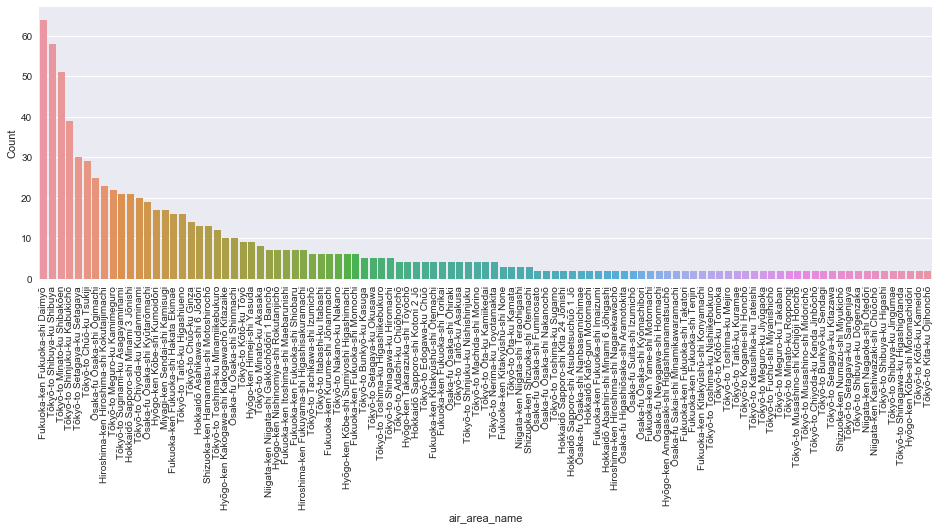

In [77]:
# Air 系统区域分布
cat_cnt_plot(as_area_cnt, figsize=(16, 5), style='seaborn')

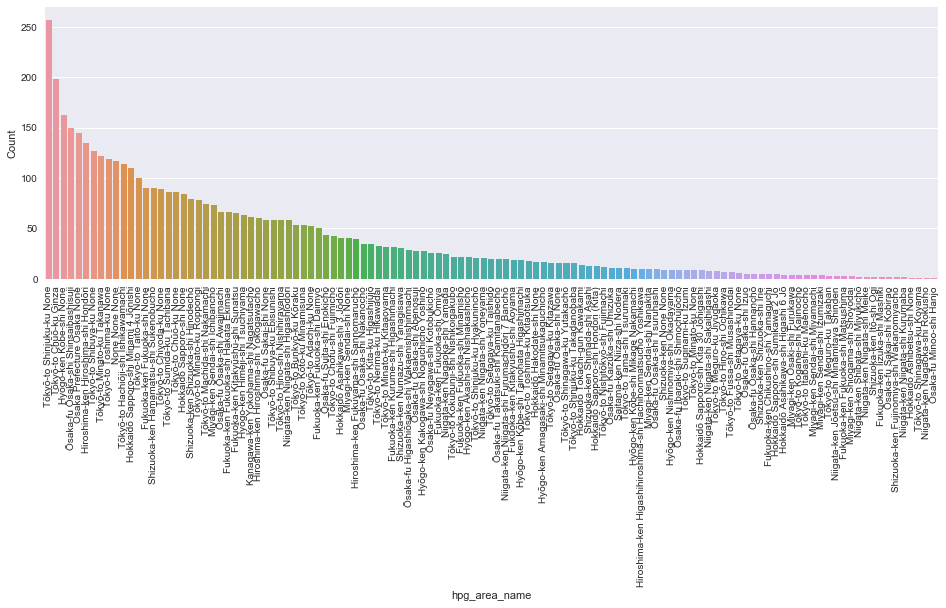

In [90]:
# Hpg 系统区域分布
cat_cnt_plot(hs_area_cnt, figsize=(16, 5), style='seaborn')

## 测试集

In [80]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


> **遗留的问题**

> Q1. 对visitors vs genre, 时间因素对visitors的影响, 区域因素对visitors的影响进行数据分析

> Q2. benchmark模型

> Q3. 特征工程

## 特征间的关系

### 1. visitor vs [genre \_ area \_ dayofweek _ ...]
---
**FINDINGS**
1. 会不会有南北差异、内陆vs海边之类的东西（日本有内陆吗=。=）

In [21]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [22]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [24]:
tmp = data['tra'].merge(data['as'], on='air_store_id')
tmp.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [30]:
tmp.loc[tmp['visitors'] == 877]

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
85314,air_cfdeb326418194ff,2017-03-08,877,Bar/Cocktail,Tōkyō-to Toshima-ku Minamiikebukuro,35.726118,139.716605


In [60]:
# 每种类型的客户数
genre_cnt_all = tmp.groupby('air_genre_name')['visitors'].sum().sort_index()
genre_cnt_mean = tmp.groupby('air_genre_name')['visitors'].mean().sort_index()
genre_cnt_mid = tmp.groupby('air_genre_name')['visitors'].median().sort_index()

'''
genre_cnt_all = genre_cnt_all.to_frame('cnt')
genre_cnt_all.loc[:, 'type'] = 'all'
genre_cnt_mean = genre_cnt_mean.to_frame('cnt')
genre_cnt_mean.loc[:, 'type'] = 'mean'
genre_cnt_mid = genre_cnt_mid.to_frame('cnt')
genre_cnt_mid.loc[:, 'type'] = 'mid'
'''

"\ngenre_cnt_all = genre_cnt_all.to_frame('cnt')\ngenre_cnt_all.loc[:, 'type'] = 'all'\ngenre_cnt_mean = genre_cnt_mean.to_frame('cnt')\ngenre_cnt_mean.loc[:, 'type'] = 'mean'\ngenre_cnt_mid = genre_cnt_mid.to_frame('cnt')\ngenre_cnt_mid.loc[:, 'type'] = 'mid'\n"

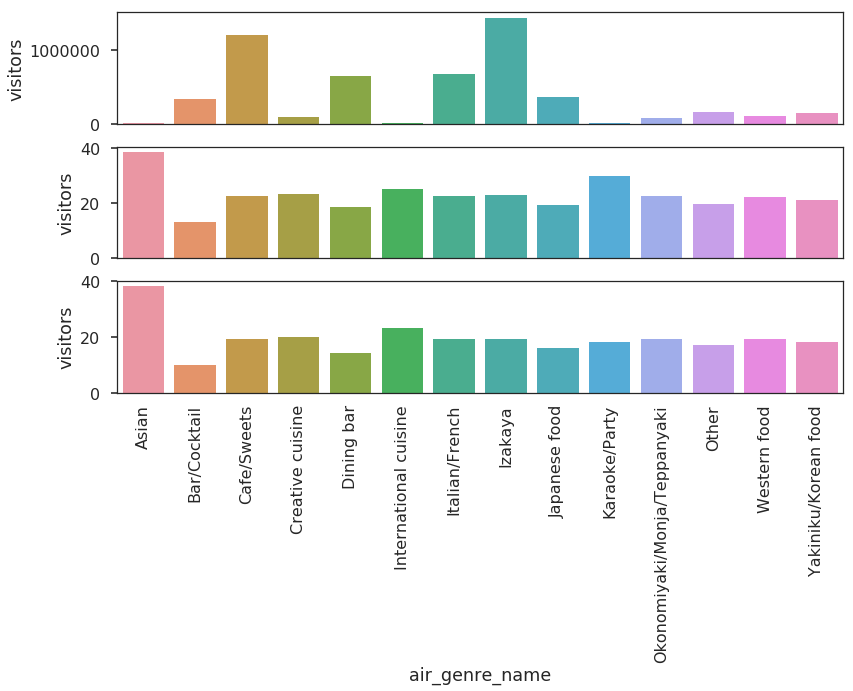

In [75]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(13, 7))
sns.barplot(genre_cnt_all.index, genre_cnt_all, ax=ax0)
ax0.get_xaxis().set_visible(False)
sns.barplot(genre_cnt_mean.index, genre_cnt_mean, ax=ax1)
ax1.get_xaxis().set_visible(False)
g = sns.barplot(genre_cnt_mid.index, genre_cnt_mid, ax=ax2)
locs, labels = plt.xticks()
_ = g.set_xticklabels(labels, rotation=90)

In [94]:
genre_area = pd.pivot_table(columns='air_genre_name', index='air_area_name', values='visitors', aggfunc=np.sum, data=tmp).fillna(0)

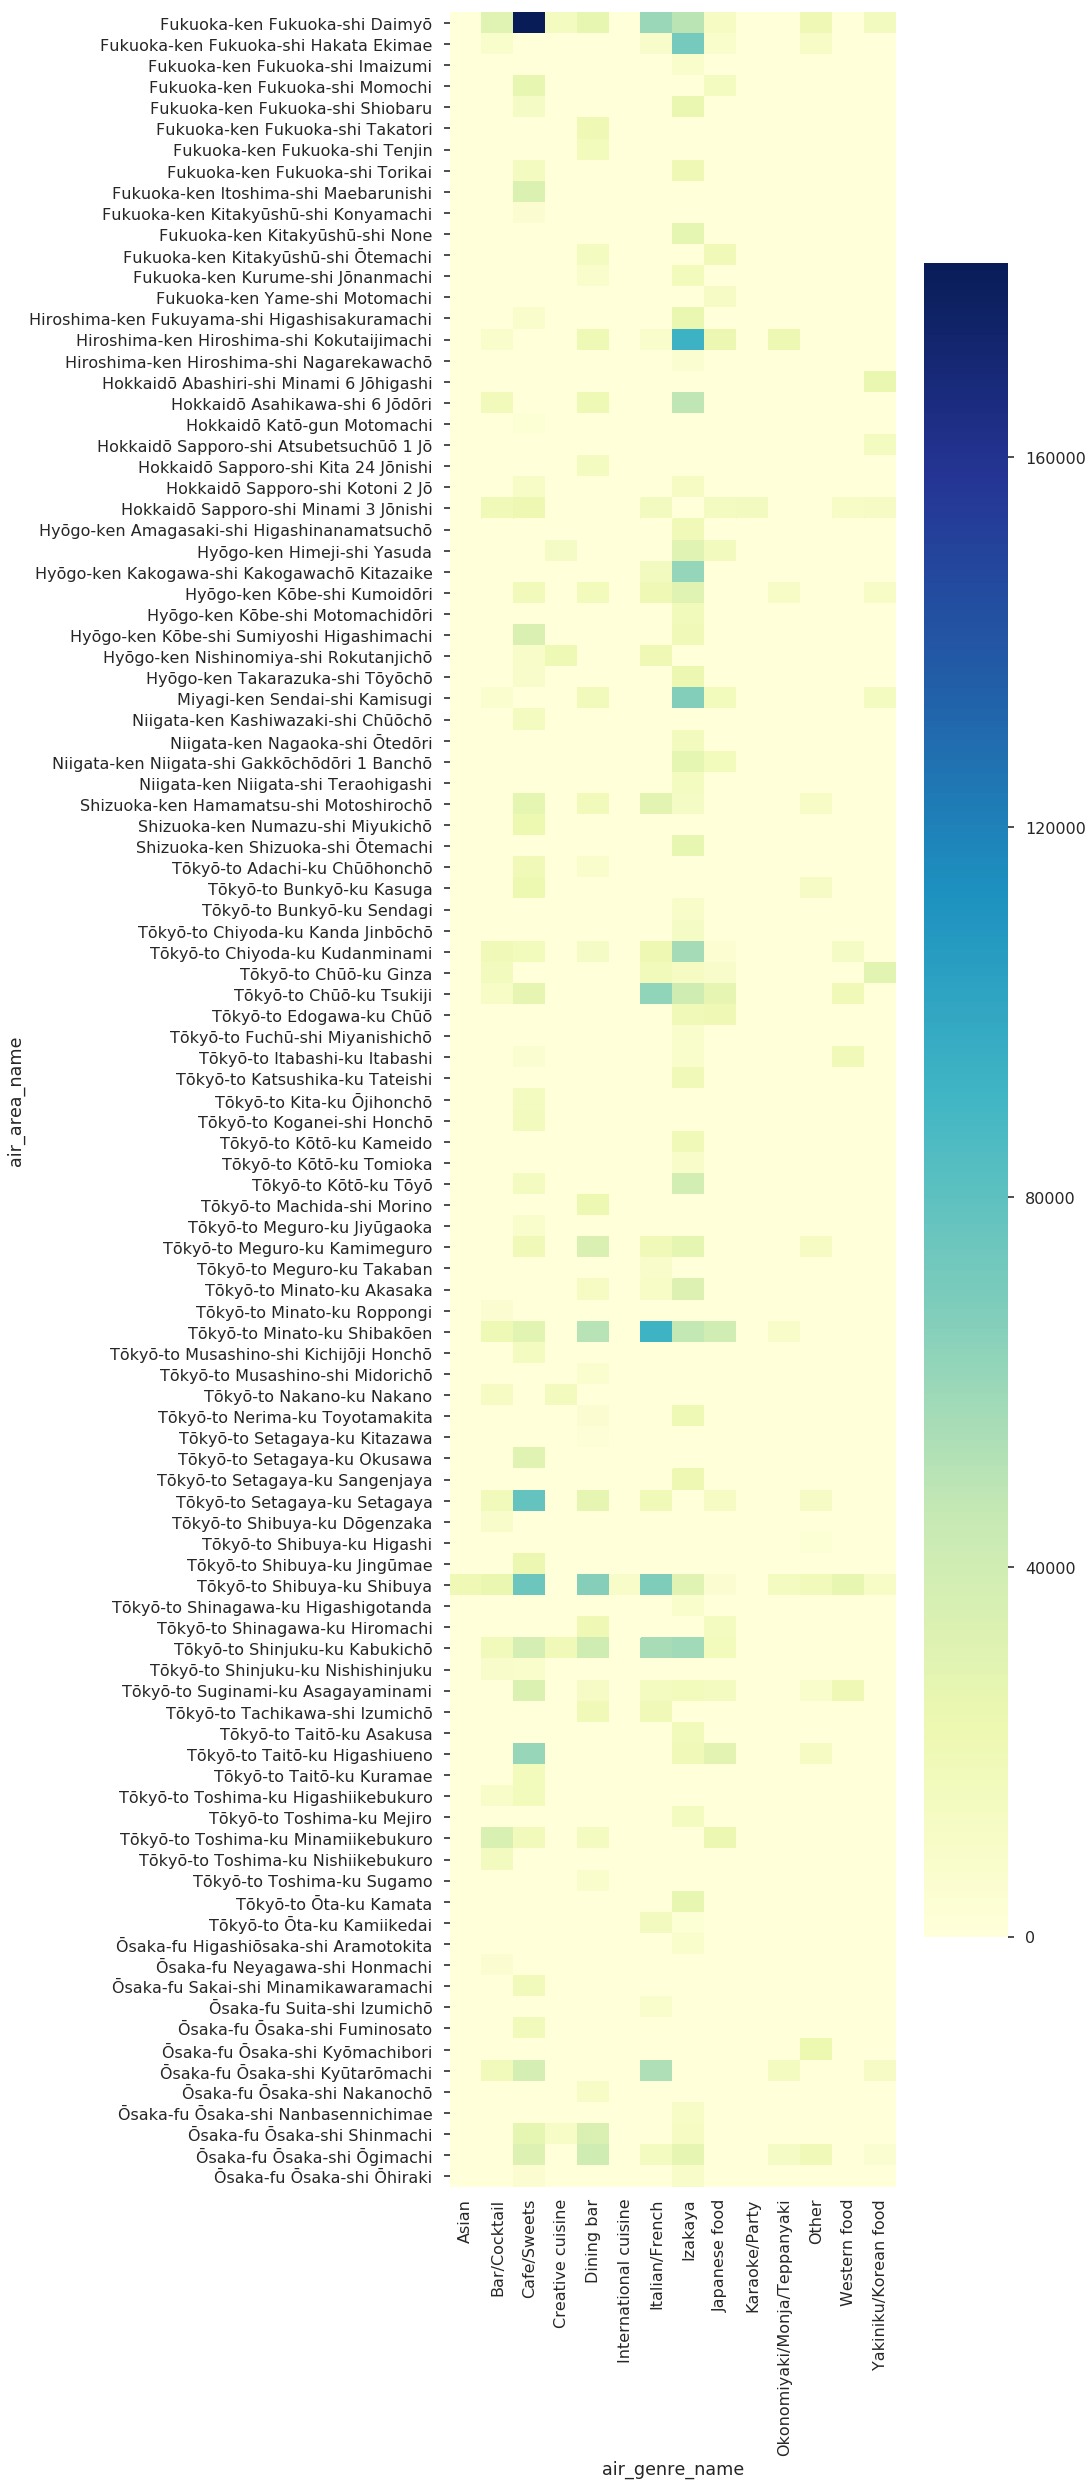

In [102]:
fig, ax = plt.subplots(figsize=(10,40))
ax = sns.heatmap(genre_area, cmap="YlGnBu", )